In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import time
import timeit


In [386]:
# Problem 1

# Create a routine for calculating an exponentially weighted covariance matrix
problem1_df = pd.read_csv("DailyReturn.csv")
problem1_df=problem1_df.rename(columns={"Unnamed: 0": "Date"})

def Cal_weight(lamda,n):
    w=np.zeros(n)
    total_w=0
    for i in range(n):
        tmp=(1-lamda)*pow(lamda,i-1)
        w[i]=tmp
        total_w+=tmp

    w=w/total_w
    return w
    
def Cal_cov(w,x,y):
    n=len(x)
    cov=0
    x_mean=np.mean(x)
    y_mean=np.mean(y)
    
    for i in range(n):
        cov+=(x[i]-x_mean)*(y[i]-y_mean)*w[n-1-i]
    
    return cov

problem1_df2=problem1_df.drop(columns='Date')

def Cal_cov_matrix(lamda,df):
        
    n_assets=df.shape[1]
    n_date=df.shape[0]

    cov_mat=np.zeros((n_assets,n_assets))

    weight=Cal_weight(lamda,n_date)
    cols=df.columns

    for i in range(n_assets):
        x=cols[i]
        cov_mat[i][i]=Cal_cov(weight,df[x],df[x])
        for j in range(i+1,n_assets):
            y=cols[j]
            cov_mat[i][j]=Cal_cov(weight,df[x],df[y])
            cov_mat[j][i]=cov_mat[i][j]
    return np.array(cov_mat)



In [207]:
def expWeight(n, nambda):
    weights = np.zeros(n)
    for i in range(n):
        weights[i] = (1 - nambda) * pow(nambda, n -i + 1) 
    #in the input data, the latest value is at the bottom
    #so generating weights accordingly (largest weight should be at the back)
    weights = weights / sum(weights)
    return weights

#calculate the weighted covariance between two variables
def cov_2arrays(x, y, w):
    cov = 0
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    n = len(x)
    for i in range(n):
        cov += w[i] * (x[i] - mean_x) * (y[i] - mean_y)
    return cov

#getting covariance matrix (df is the dataframe holding the data)
def expWeightedCov(df, nambda):
    n, m = df.shape
    weights = expWeight(n, nambda)
    Cov = pd.DataFrame(index = df.columns[1:], columns = df.columns[1:]) #the first column is the date
    for i in range(m - 1):
        for j in range(m - 1):
            Cov.iloc[i][j] = cov_2arrays(df.iloc[:, i + 1], df.iloc[:, j + 1], weights)
    return Cov

In [186]:
n_assets=problem1_df2.shape[1]

col_name1=problem1_df2.columns[0]
col_name2=problem1_df2.columns[0]
weight=Cal_weight(0.97,problem1_df2.shape[0])
Cal_cov(weight,problem1_df2[col_name1],problem1_df2[col_name2])

8.411069089105855e-05

In [387]:
Cal_cov_matrix(0.97,problem1_df2)

array([[8.41106909e-05, 1.06945662e-04, 1.21760871e-04, ...,
        1.25484463e-04, 8.11331555e-05, 8.61130395e-05],
       [1.06945662e-04, 2.68752303e-04, 1.97531665e-04, ...,
        1.15658764e-04, 3.74977522e-05, 8.22220854e-05],
       [1.21760871e-04, 1.97531665e-04, 2.91157502e-04, ...,
        8.30278956e-05, 3.31844912e-05, 7.34713753e-05],
       ...,
       [1.25484463e-04, 1.15658764e-04, 8.30278956e-05, ...,
        7.47889224e-04, 2.68371109e-04, 2.00639601e-04],
       [8.11331555e-05, 3.74977522e-05, 3.31844912e-05, ...,
        2.68371109e-04, 3.08241679e-04, 8.21009546e-05],
       [8.61130395e-05, 8.22220854e-05, 7.34713753e-05, ...,
        2.00639601e-04, 8.21009546e-05, 2.62692778e-04]])

In [383]:
w=calculate_weight(0.97, df)
x=df[problem1_df2.columns[1]]
y=df[problem1_df2.columns[2]]
Cal_cov(w,x,y)

0.00019753166457453882

In [374]:
problem1_df2.columns[0]

'SPY'

In [180]:
# calculate the covariance
    
def weighted_pair(x, y, weight):
    n = len(x)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    cov = 0
    for i in range(n):
        cov += weight[n - 1 - i]*(x[i] - mean_x) * (y[i] - mean_y)
    return cov

def calculate_weight(lamb, df):
    X = df.index.values
    weight = [(1-lamb)*lamb**(i-1) for i in X]
    weight_adjust = [weight[i]/sum(weight) for i in X]
    return weight_adjust

def weighted_cov(lamb, df):

    n = df.shape[1]
    T = len(df)
    weight = calculate_weight(lamb, df)
    cov_mat = pd.DataFrame(np.zeros((n, n)))
    for i in range(n):
        x = df.iloc[:, i]
        cov_mat.iloc[i, i] = weighted_pair(x, x, weight)
        for j in range(i+1):
            y = df.iloc[:, j]
            cov_mat.iloc[i, j] = weighted_pair(x, y, weight)
            cov_mat.iloc[j, i] = cov_mat.iloc[i, j]

    return np.array(cov_mat)

cov_mat = weighted_cov(0.97, problem1_df2)

In [388]:
# PCA
def PCA(cov_mat):
    
    vals,vecs =np.linalg.eigh(cov_mat)
    tv=np.sum(vals)
    
    explain_total=0
    explain_list=[]
    
    for i in vals:
        if i > 0:
            explain_total+=i
            explain_list.append(i)
            
    
   
    exp_list=sorted(explain_list,reverse=True)
    exp_cum_list=np.cumsum(exp_list)
    exp_cum_list=np.divide(exp_cum_list,explain_total)
    
    return exp_cum_list

In [284]:
PCA(cov_mat)

[0.2996083233628427,
 0.14255828877410984,
 0.06470821026557838,
 0.048112680758734906,
 0.04403962613208367,
 0.03353912214335836,
 0.03163711889712542,
 0.026511702903026672,
 0.025467226265421368,
 0.01904706598411329,
 0.017815725029058305,
 0.01746473531189978,
 0.015502478462392909,
 0.014730357586606038,
 0.013899619551523164,
 0.01236600652550515,
 0.012007370608375102,
 0.011601405469598015,
 0.010988717694086542,
 0.010072581157062032,
 0.009225349581527391,
 0.008263278923082993,
 0.008055082392371108,
 0.007017870304052114,
 0.006768564483916587,
 0.006422509014681425,
 0.006018250254589392,
 0.005894928422045042,
 0.005569001621499358,
 0.00547538222399199,
 0.005173245151404841,
 0.00435742769182999,
 0.0042718145422844245,
 0.004193067154604927,
 0.003749482035237707,
 0.003654846178279814,
 0.003462222959707006,
 0.003215170820616278,
 0.0030950348766786437,
 0.0027580421060627238,
 0.0025000143719568807,
 0.0024627860520346797,
 0.002138064981379226,
 0.001852685865573

In [218]:
eigValue = np.linalg.eigh(np.array(cov_mat,dtype=float))[0]

#keep only positive real value
x = eigValue.shape[0]
for i in range (x):
    if (eigValue[i] < 1e-8) or (np.imag(eigValue[i]) != 0) :
        eigValue[i] = 0
eigValue = np.real(eigValue)
tot = sum(eigValue)
var_exp = eigValue/tot
var_exp.sort()
var_exp = var_exp[::-1]
cum_var_exp = np.cumsum(var_exp)

In [219]:
cum_var_exp

array([0.63393612, 0.73149279, 0.77851225, 0.81321381, 0.83561193,
       0.85597782, 0.87230673, 0.88653562, 0.8994675 , 0.91030421,
       0.91967258, 0.92811145, 0.93652613, 0.94438479, 0.94947762,
       0.95437649, 0.95895074, 0.96286608, 0.96657813, 0.96977711,
       0.97289789, 0.97523307, 0.97748492, 0.97962154, 0.98158331,
       0.98333363, 0.98506437, 0.98645185, 0.98783172, 0.98910751,
       0.9902817 , 0.99138336, 0.9924521 , 0.99350203, 0.99439944,
       0.9952737 , 0.99602561, 0.99655787, 0.99708646, 0.99759302,
       0.99805203, 0.99842028, 0.9987674 , 0.9990874 , 0.99935323,
       0.99961124, 0.99979792, 0.99988185, 0.99993336, 0.99998284,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [294]:
PCA2(cov_mat)

array([1.3183584 , 1.52124107, 1.61902458, 1.6911913 , 1.73777133,
       1.78012502, 1.81408327, 1.84367422, 1.87056787, 1.8931043 ,
       1.91258714, 1.93013694, 1.94763644, 1.96397961, 1.97457087,
       1.98475875, 1.99427154, 2.00241404, 2.01013376, 2.01678648,
       2.02327659, 2.02813291, 2.03281595, 2.03725935, 2.04133913,
       2.04497915, 2.04857848, 2.05146394, 2.05433357, 2.05698674,
       2.05942863, 2.06171969, 2.06394228, 2.06612575, 2.06799205,
       2.06981019, 2.07137389, 2.0724808 , 2.07358008, 2.07463354,
       2.07558813, 2.07635395, 2.07707584, 2.07774131, 2.07829414,
       2.07883071, 2.07921893, 2.07939347, 2.0795006 , 2.0796035 ,
       2.07963919])

In [293]:
PCA(cov_mat)

array([0.63393612, 0.73149279, 0.77851225, 0.81321381, 0.83561193,
       0.85597782, 0.87230673, 0.88653562, 0.8994675 , 0.91030421,
       0.91967258, 0.92811145, 0.93652613, 0.94438479, 0.94947762,
       0.95437649, 0.95895074, 0.96286608, 0.96657813, 0.96977711,
       0.97289789, 0.97523307, 0.97748492, 0.97962154, 0.98158331,
       0.98333363, 0.98506437, 0.98645185, 0.98783172, 0.98910751,
       0.9902817 , 0.99138336, 0.9924521 , 0.99350203, 0.99439944,
       0.9952737 , 0.99602561, 0.99655787, 0.99708646, 0.99759302,
       0.99805203, 0.99842028, 0.9987674 , 0.9990874 , 0.99935323,
       0.99961124, 0.99979792, 0.99988185, 0.99993336, 0.99998284,
       1.        ])

In [290]:
def PCA2(cov_matrix):
    eigenvalue, eigenvector = np.linalg.eigh(cov_matrix)
    eigenvalue = sorted(eigenvalue, reverse = True)
    total_eigen = np.sum(eigenvalue)
    explain = 0
    pctExplained_list = []
    
    for i in range(len(eigenvalue)):
        if eigenvalue[i] < 0:
            break
        explain += eigenvalue[i]
        pctExplained_list.append(explain/total_eigen)
    return np.array(pctExplained_list)


# lamb = [0.1, 0.3, 0.5, 0.75, 0.90, 0.97, 0.99]
# fig, ax = plt.subplots(figsize=(8,6))

# for la in lamb:
#     cov_mat = weighted_cov(la, df)
#     PCA_list = PCA2(cov_mat)
#     ax.plot(PCA_list, label = f"λ = {la}")
# ax.legend(loc='best')
# ax.set_title("pct Explainded for different λ", fontsize=15)

In [282]:
PCA_list

array([0.29960832, 0.44216661, 0.50687482, 0.5549875 , 0.59902713,
       0.63256625, 0.66420337, 0.69071507, 0.7161823 , 0.73522937,
       0.75304509, 0.77050983, 0.7860123 , 0.80074266, 0.81464228,
       0.82700829, 0.83901566, 0.85061706, 0.86160578, 0.87167836,
       0.88090371, 0.88916699, 0.89722207, 0.90423994, 0.91100851,
       0.91743102, 0.92344927, 0.9293442 , 0.9349132 , 0.94038858,
       0.94556183, 0.94991925, 0.95419107, 0.95838413, 0.96213362,
       0.96578846, 0.96925069, 0.97246586, 0.97556089, 0.97831893,
       0.98081895, 0.98328173, 0.9854198 , 0.98727248, 0.98904843,
       0.99056177, 0.99202584, 0.99322603, 0.99439622, 0.99529513,
       0.99616525, 0.99689255, 0.99757571, 0.99815446, 0.99868218,
       0.99915388, 0.99950957, 0.99979758, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

Text(0.5, 1.0, 'pct Explainded for different λ')

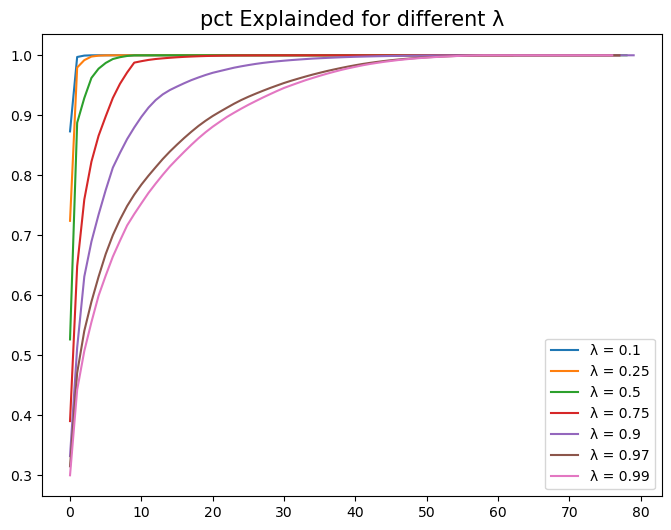

In [389]:
lamb = [0.1,0.25,0.5,0.75,0.9,0.97,0.99]
n=problem1_df2.shape[0]
fig, ax = plt.subplots(figsize=(8,6))

for la in lamb:
    cov_mat = Cal_cov_matrix(la,problem1_df2)
    PCA_list = PCA(cov_mat)
    ax.plot(PCA_list, label = f"λ = {la}")
    
    
ax.legend(loc='best')
ax.set_title("pct Explainded for different λ", fontsize=15)

In [278]:
# Problem 2

# implement chol_psd 
def chol_psd(root,a):
    n=len(a)
    
    root=np.array([[0.0]*n]*n)
    
    for j in range(n):
        if j==0:
            s=0
        else:
            s=np.matmul(root[j,:j],root[j,:j].T)
            
        tmp=a[j,j]-s
        # if -1e-8 <=tmp<=0:
        #     tmp=0.0
            
        root[j,j]=np.sqrt(tmp)
        if root[j,j]==0:
            continue
        
        ir=1.0/root[j,j]
        
        for i in range((j+1),n):
            s=np.matmul(root[i,:j],root[j,:j].T) 
            root[i,j]=(a[i,j]-s)*ir
            
            
    return root

#implement near_psd:

def near_psd(a,epsilon=0.0):
    
    
    n=len(a)
    
    invSD=np.array([])
    out=a.copy()
    
    if np.count_nonzero(np.diag(a)==1) !=n:
        invSD=np.diagflat(1/np.sqrt(np.diag(out)))
        tmp=np.matmul(out,invSD)
        out=np.matmul(invSD,tmp)
        
    vals,vecs=np.linalg.eigh(a)
    vals=np.maximum(vals,epsilon)
    temp=np.matmul(vecs,vecs)
    T=1/np.matmul(vecs*vecs,vals)
    T=np.diagflat(np.sqrt(T))
    l=np.diagflat(np.sqrt(vals))
    tmp2=np.matmul(T,vecs)
    B=np.matmul(tmp2,l)
    out=np.matmul(B,B.T)
    
    if len(invSD) != 0:
        invSD = np.diagflat(1/np.diag(invSD))
        tmp3=np.matmul(out,invSD)
        out=np.matmul(invSD,tmp3)
        
    return out


In [271]:
# Implement Higham 2002

def Frobenius_Norm(A):
    s=0
    for i in range(len(A)):
        for j in range(len(A)):
            s+=A[i,j]**2
            
    return s

def ProjectionU(A):
    p=A.copy()
    
    for i in range(len(A)):
       p[i,i]=1
    return p

def ProjectionS(A,W):
    w_sqrt=np.sqrt(W)
    tmp=np.matmul(w_sqrt,A)
    
    tmp2=np.matmul(tmp,w_sqrt)
    
    vals , vecs = np.linalg.eigh(A)
    vals = np.maximum(vals,0)
    val_diag= np.diagflat(vals)
    
    tmp=np.matmul(vecs,val_diag)
    p=np.matmul(tmp,vecs.T)
    
    return p


def Higham_2002(A,iteration=1000):
    Lag_deltaS = 0
   
    Lag_Y = A
    
    Lag_Gamma = np.inf
    
    weights=np.ones(len(A))
    
    tol = 1e-10
    
    for i in range(iteration):
        R = Lag_Y - Lag_deltaS
        X=ProjectionS(R,weights)
        deltaS=X-R
        Y=ProjectionU(X)
        Gamma=Frobenius_Norm(Y-A)
        
        if abs(Gamma - Lag_Gamma)<tol:
            break
        
        Lag_deltaS=deltaS
        Lag_Y=Y
        Lag_Gamma=Gamma
        
    return Y
    



In [255]:
# generate NON PSD
    
def gen_non_psd(n):
    sigma = np.full((n,n),0.9)
    for i in range(n):
        sigma[i,i]=1
    
    sigma[0,1] = 0.7357
    sigma[1,0] = 0.7357 
    return sigma

In [272]:
A=gen_non_psd(10)
Higham_2002(A)

array([[1.        , 0.75489607, 0.89529666, 0.89529666, 0.89529666,
        0.89529666, 0.89529666, 0.89529666, 0.89529666, 0.89529666],
       [0.75489607, 1.        , 0.89529666, 0.89529666, 0.89529666,
        0.89529666, 0.89529666, 0.89529666, 0.89529666, 0.89529666],
       [0.89529666, 0.89529666, 1.        , 0.90115239, 0.90115239,
        0.90115239, 0.90115239, 0.90115239, 0.90115239, 0.90115239],
       [0.89529666, 0.89529666, 0.90115239, 1.        , 0.90115239,
        0.90115239, 0.90115239, 0.90115239, 0.90115239, 0.90115239],
       [0.89529666, 0.89529666, 0.90115239, 0.90115239, 1.        ,
        0.90115239, 0.90115239, 0.90115239, 0.90115239, 0.90115239],
       [0.89529666, 0.89529666, 0.90115239, 0.90115239, 0.90115239,
        1.        , 0.90115239, 0.90115239, 0.90115239, 0.90115239],
       [0.89529666, 0.89529666, 0.90115239, 0.90115239, 0.90115239,
        0.90115239, 1.        , 0.90115239, 0.90115239, 0.90115239],
       [0.89529666, 0.89529666, 0.9011523

In [265]:
def getPS(R, weights):
    w_half = np.sqrt(weights)
    R_wtd = w_half * R *w_half
    vals, vecs = np.linalg.eigh(R_wtd)
    #let the eigenvalue system with negative values set to 0
    R_wtd = np.matmul((vecs * np.maximum(vals, 0)), (np.transpose(vecs)))
    X = (1 / w_half) * R_wtd *(1 / w_half)
    return X

def getPU(X):
    #assuming w is diagonal
    Y = X
    np.fill_diagonal(Y, 1)
    return Y

def f_norm (M1, M2, weights):
    w_half = np.sqrt(weights)
    A_w = w_half * (M1 - M2) *w_half
    f_norm = np.sum(A_w * A_w)
    return f_norm
    

def wgtnorm(A, Y, Y_old, weights):

    norm_Y = f_norm(Y,  A, weights)
    norm_Y_old = f_norm(Y_old,  A, weights)
    norml = norm_Y - norm_Y_old
    return norml

def higham_psd(A, max_iterations=1000, tolerance = 1e-9):
    
    n = A.shape[0]
    delta_s = np.zeros(np.shape(A))

    norml = np.inf

    weights = np.ones(np.shape(A)[0])
    Y = np.copy(A)
    

    iteration = 0
    
    while (norml > tolerance) or (sum(np.linalg.eigh(Y)[0]>-1e-8) < n):
    # if it converge, it is guarenteed to be psd
        if iteration > max_iterations:
            print("No solution found in " + str(max_iterations) + " iterations")
            return A

        R = Y - delta_s
        
        #PS update
        X = getPS(R, weights)

        delta_s = X - R       
        
        Y_old = np.copy(Y)
        #PU update
        Y = getPU(X)
     
        #get norm
        norml = wgtnorm(A, Y, Y_old, weights)
        
        iteration += 1
    return Y

In [266]:
higham_psd(A)

array([[1.        , 0.75489607, 0.89529666, 0.89529666, 0.89529666,
        0.89529666, 0.89529666, 0.89529666, 0.89529666, 0.89529666],
       [0.75489607, 1.        , 0.89529666, 0.89529666, 0.89529666,
        0.89529666, 0.89529666, 0.89529666, 0.89529666, 0.89529666],
       [0.89529666, 0.89529666, 1.        , 0.90115239, 0.90115239,
        0.90115239, 0.90115239, 0.90115239, 0.90115239, 0.90115239],
       [0.89529666, 0.89529666, 0.90115239, 1.        , 0.90115239,
        0.90115239, 0.90115239, 0.90115239, 0.90115239, 0.90115239],
       [0.89529666, 0.89529666, 0.90115239, 0.90115239, 1.        ,
        0.90115239, 0.90115239, 0.90115239, 0.90115239, 0.90115239],
       [0.89529666, 0.89529666, 0.90115239, 0.90115239, 0.90115239,
        1.        , 0.90115239, 0.90115239, 0.90115239, 0.90115239],
       [0.89529666, 0.89529666, 0.90115239, 0.90115239, 0.90115239,
        0.90115239, 1.        , 0.90115239, 0.90115239, 0.90115239],
       [0.89529666, 0.89529666, 0.9011523

In [260]:
Higham_near_psd(A)

array([[1.        , 0.75489607, 0.89529666, 0.89529666, 0.89529666,
        0.89529666, 0.89529666, 0.89529666, 0.89529666, 0.89529666],
       [0.75489607, 1.        , 0.89529666, 0.89529666, 0.89529666,
        0.89529666, 0.89529666, 0.89529666, 0.89529666, 0.89529666],
       [0.89529666, 0.89529666, 1.        , 0.90115239, 0.90115239,
        0.90115239, 0.90115239, 0.90115239, 0.90115239, 0.90115239],
       [0.89529666, 0.89529666, 0.90115239, 1.        , 0.90115239,
        0.90115239, 0.90115239, 0.90115239, 0.90115239, 0.90115239],
       [0.89529666, 0.89529666, 0.90115239, 0.90115239, 1.        ,
        0.90115239, 0.90115239, 0.90115239, 0.90115239, 0.90115239],
       [0.89529666, 0.89529666, 0.90115239, 0.90115239, 0.90115239,
        1.        , 0.90115239, 0.90115239, 0.90115239, 0.90115239],
       [0.89529666, 0.89529666, 0.90115239, 0.90115239, 0.90115239,
        0.90115239, 1.        , 0.90115239, 0.90115239, 0.90115239],
       [0.89529666, 0.89529666, 0.9011523

In [ ]:
# Judge if the matrix is PSD
def if_PSD():
    

In [299]:
# Compare the results of both using the Frobenius Norm.

def cost_time(func):
    def fun(*args, **kwargs):
        t = time.perf_counter()
        result = func(*args, **kwargs)
        print(f'func {func.__name__} cost time:{time.perf_counter() - t:.8f} s')
        return result

    return fun



def compare_run_time(n):
    non_psd=gen_non_psd(n)
    print("When N= "+str(n)+", the run time of each is shown below:")
    n1 = time.time()
    npsd = near_psd(non_psd)
    n2 = time.time()
    near_t = n2 - n1
    
    h1 = time.time()
    higham = Higham_2002(non_psd)
    h2 = time.time()
    higham_t = h2 - h1
   
    print("The run time of near psd is "+str(near_t))
    print("The run time of higham2002 is "+ str(higham_t))
    return near_t,higham_t
    
    
def compare_Frob_Norm(n):
    non_psd=gen_non_psd(n)
    print("When N= "+str(n)+", the result of Frobenius Norm of each is shown below:")
    near_psdA=near_psd(non_psd)
    near_frobA=Frobenius_Norm(near_psdA-non_psd)

    higham_psdA=Higham_2002(non_psd)
    higham_frobA=Frobenius_Norm(higham_psdA-non_psd)
    
    print("The result of Frobenius Norm of near psd is "+str(near_frobA))
    print("The result of Frobenius Norm of higham2002 is "+str(higham_frobA))
    return near_frobA,higham_frobA


When N= 10, the run time of each is shown below:
The run time of near psd is 0.002010822296142578
The run time of higham2002 is 0.0029883384704589844
When N= 10, the result of Frobenius Norm of each is shown below:
The result of Frobenius Norm of near psd is 0.0027385481538506153
The result of Frobenius Norm of higham2002 is 0.0015192331193787274
When N= 100, the run time of each is shown below:
The run time of near psd is 0.041519880294799805
The run time of higham2002 is 0.14850878715515137
When N= 100, the result of Frobenius Norm of each is shown below:
The result of Frobenius Norm of near psd is 0.07441520643491044
The result of Frobenius Norm of higham2002 is 0.007164374540474617
When N= 500, the run time of each is shown below:
The run time of near psd is 0.02300095558166504
The run time of higham2002 is 3.868165969848633
When N= 500, the result of Frobenius Norm of each is shown below:
The result of Frobenius Norm of near psd is 0.39378468349905377
The result of Frobenius Norm 

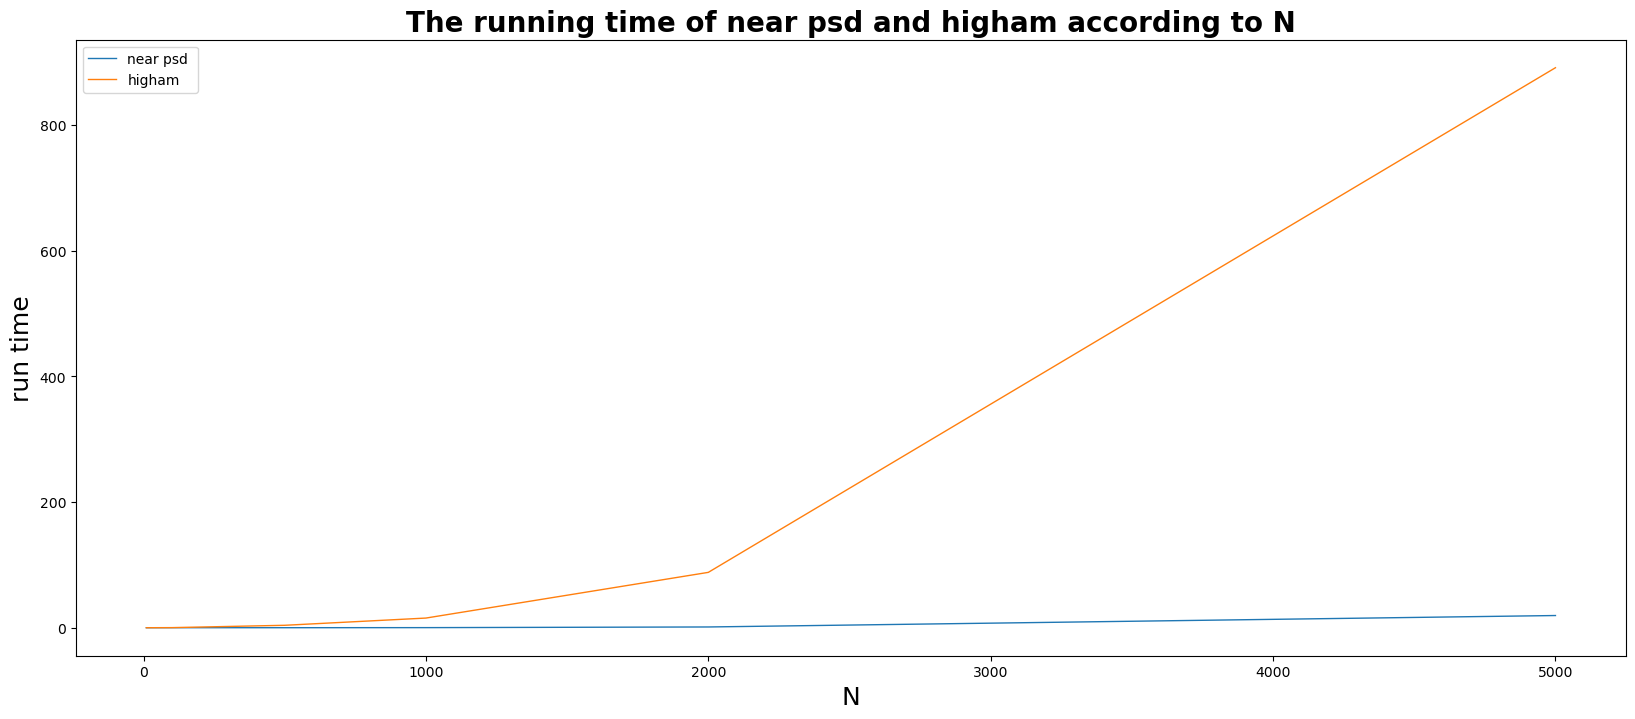

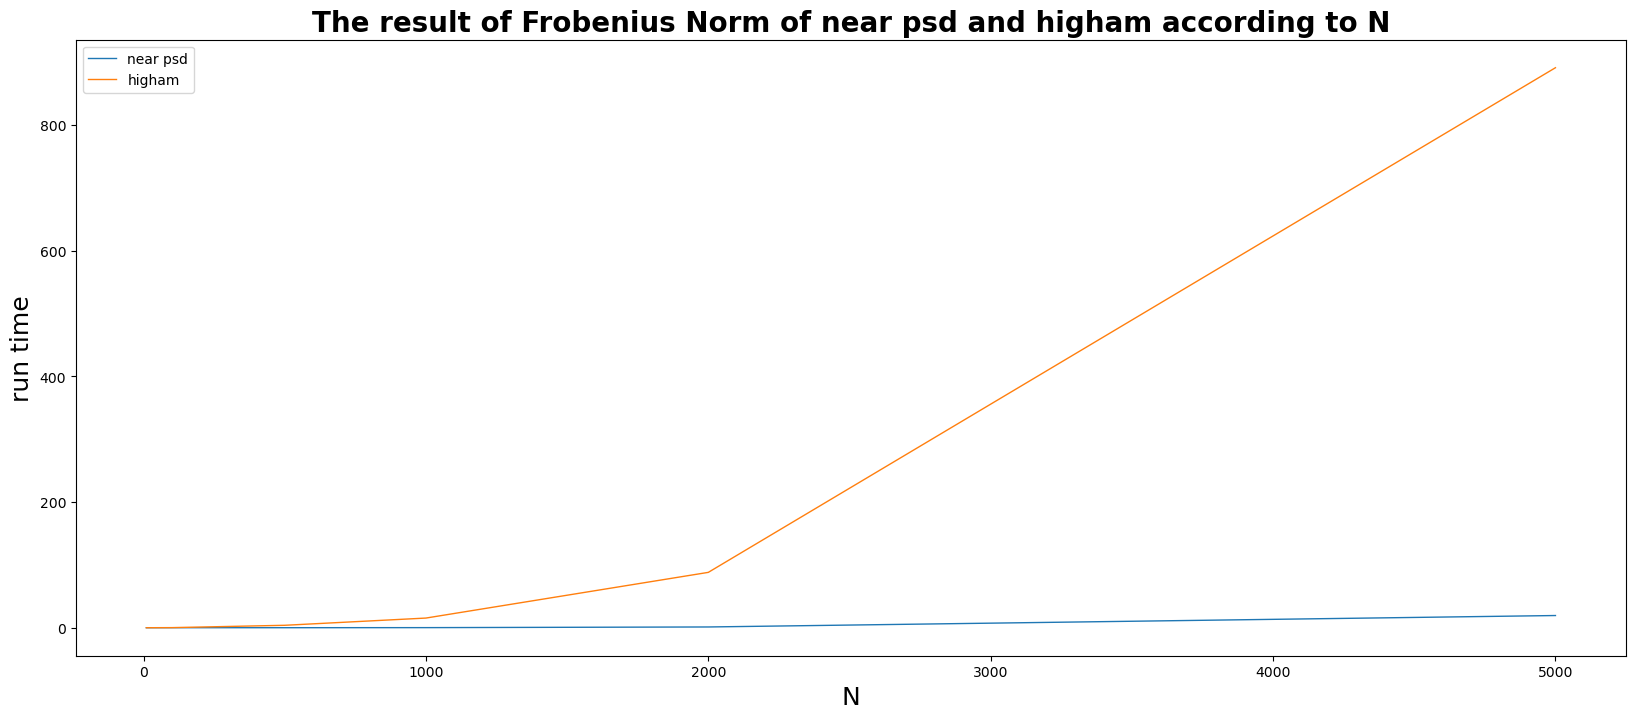

In [302]:
N=[10,100,250,500,750,1000]
near_time=[]
near_f=[]
high_time=[]
high_f=[]

for i in N:
    n_t,h_t=compare_run_time(i)
    n_f,h_f=compare_Frob_Norm(i)
    near_time.append(n_t)
    near_f.append(n_f)
    high_time.append(h_t)
    high_f.append(h_f)

x=N
y1=near_time
y2=high_time
plt.figure(figsize=(20,8))
plt.plot(x,y1,lw=1,ms=4,label='near psd ')
plt.plot(x,y2,lw=1,ms=4,label='higham')
plt.title('The running time of near psd and higham according to N',fontsize=20,fontweight='heavy',verticalalignment='baseline')
plt.xlabel('N',fontsize=18)
plt.ylabel('run time',fontsize=18)
plt.legend()
plt.show()

y3=near_f
y4=high_f
plt.figure(figsize=(20,8))
plt.plot(x,y1,lw=1,ms=4,label='near psd')
plt.plot(x,y2,lw=1,ms=4,label='higham')
plt.title('The result of Frobenius Norm of near psd and higham according to N',fontsize=20,fontweight='heavy',verticalalignment='baseline')
plt.xlabel('N',fontsize=18)
plt.ylabel('run time',fontsize=18)
plt.legend()
plt.show()
    

In [360]:
# Problem 3

problem3_df = pd.read_csv("DailyReturn.csv")
problem3_df=problem3_df.rename(columns={"Unnamed: 0": "Date"})
problem3_df2=problem3_df.drop(columns="Date")

# def cal_cov(x,y):
#     n=len(x)
#     tot=0
#     avg_x=np.mean(x)
#     avg_y=np.mean(y)
    
#     for i in range(n):
#         tot+=(x[i]-avg_x)*(y[i]-avg_x)
    
#     return tot/n

def covariance_matrix(df):
    n = df.shape[0]
    mean = np.mean(df, axis=0)
    df = df - mean
    cov_matrix = np.dot(df.T, df) / (n-1)
    return cov_matrix

def PearsonVar(df):
    cov_mat=covariance_matrix(df)
    var=np.diag(cov_mat)
    
    return var

def PearsonCorr(df):
    n_date=df.shape[0]
    n_assets =df.shape[1]
    cov_mat=covariance_matrix(df)
    corr_mat=np.zeros((n_assets,n_assets))
    var=PearsonVar(df)
    std=np.sqrt(var)
    for i in range(n_assets):
        corr_mat[i][i]=cov_mat[i][i]/(std[i]*std[i])
        for j in range(i+1,n_assets):
            corr_mat[i][j]=cov_mat[i][j]/(std[i]*std[j])
            corr_mat[j][i]=cov_mat[i][j]
    
    return corr_mat
    
            
            
def EWVar(lamda,df):
    EWcov=Cal_cov_matrix(lamda,df)       
    EWvar=np.diag(EWcov)
    return EWvar


    
def EWCorr(lamda,df):
    EWcov=Cal_cov_matrix(lamda,df)
    n_date=df.shape[0]
    n_assets =df.shape[1]
    EWcorr_mat=np.zeros((n_assets,n_assets))
    var=EWVar(lamda,df)
    std=np.sqrt(var)
    for i in range(n_assets):
        EWcorr_mat[i][i]=EWcov[i][i]/(std[i]*std[i])
        for j in range(i+1,n_assets):
            EWcorr_mat[i][j]=EWcov[i][j]/(std[i]*std[j])
            EWcorr_mat[j][i]=EWcov[i][j]
            
    return EWcorr_mat
    
def Combine_cov(Corr,std):
    n=len(std)
    new_cov=np.zeros((n,n))
    for i in range(n):
        new_cov[i][i]=Corr[i][i]*(std[i]*std[i])
        for j in range(i+1,n_assets):
            new_cov[i][j]=Corr[i][j]*(std[i]*std[j])
            new_cov[j][i]=new_cov[i][j]
            
    return new_cov
    
# Combine 2X2

New_cov = []

pCorr=PearsonCorr(problem3_df2)
pStd=PearsonVar(problem3_df2)
eCorr=EWCorr(0.97,problem3_df2)
eStd=EWCorr(0.97,problem3_df2)
new1=Combine_cov(pCorr,pStd)
new2=Combine_cov(pCorr,eStd)
new3=Combine_cov(eCorr,eStd)
new4=Combine_cov(eCorr,pStd)

New_cov.append(new1)
New_cov.append(new2)
New_cov.append(new3)
New_cov.append(new4)

#Direct Simulate

def direct_simulate(cov_mat, size):
    n=len(cov_mat)
    
    Gen_rand = np.random.normal(size = (n,size))
    root = chol_psd(cov_mat)
    
    ds=np.matmul(root,Gen_rand)
    return 

def PCA_simulate(cov_mat, explained, sample_num):
    explained_list = PCA(cov_mat)
    ix = 0
    n = len(cov_mat)

    for i in range(len(explained_list)):
        if explained_list[i]>=explained-1e-8: 
            ix = i
            break
    eigenvalue, eigenvector = np.linalg.eigh(cov_mat)
    eigenvector = eigenvector[:, (n-ix-1):]
    eigenvalue = eigenvalue[(n-ix-1):]

    L = eigenvector @ np.diag(np.sqrt(eigenvalue))
    rand_data = np.random.normal(size = (L.shape[1],sample_num))
    return L@rand_data

In [354]:
Cal_cov_matrix(0.97,problem1_df2)

array([[8.41106909e-05, 2.68752303e-04, 2.91157502e-04, ...,
        7.47889224e-04, 3.08241679e-04, 2.62692778e-04],
       [8.41106909e-05, 2.68752303e-04, 2.91157502e-04, ...,
        7.47889224e-04, 3.08241679e-04, 2.62692778e-04],
       [8.41106909e-05, 2.68752303e-04, 2.91157502e-04, ...,
        7.47889224e-04, 3.08241679e-04, 2.62692778e-04],
       ...,
       [8.41106909e-05, 2.68752303e-04, 2.91157502e-04, ...,
        7.47889224e-04, 3.08241679e-04, 2.62692778e-04],
       [8.41106909e-05, 2.68752303e-04, 2.91157502e-04, ...,
        7.47889224e-04, 3.08241679e-04, 2.62692778e-04],
       [8.41106909e-05, 2.68752303e-04, 2.91157502e-04, ...,
        7.47889224e-04, 3.08241679e-04, 2.62692778e-04]])

In [363]:
EWcov=Cal_cov_matrix(0.97,df)
n_date=df.shape[0]
n_assets =df.shape[1]
EWcorr_mat=np.zeros((n_assets,n_assets))
var=EWVar(0.97,df)
std=np.sqrt(var)
for i in range(n_assets):
    EWcorr_mat[i][i]=EWcov[i][i]/(std[i]*std[i])
    for j in range(i+1,n_assets):
        EWcorr_mat[i][j]=EWcov[i][j]/(std[i]*std[j])
        EWcorr_mat[j][i]=EWcov[i][j]

In [369]:
Cal_cov_matrix(0.97,df)

array([[8.41106909e-05, 2.68752303e-04, 2.91157502e-04, ...,
        7.47889224e-04, 3.08241679e-04, 2.62692778e-04],
       [8.41106909e-05, 2.68752303e-04, 2.91157502e-04, ...,
        7.47889224e-04, 3.08241679e-04, 2.62692778e-04],
       [8.41106909e-05, 2.68752303e-04, 2.91157502e-04, ...,
        7.47889224e-04, 3.08241679e-04, 2.62692778e-04],
       ...,
       [8.41106909e-05, 2.68752303e-04, 2.91157502e-04, ...,
        7.47889224e-04, 3.08241679e-04, 2.62692778e-04],
       [8.41106909e-05, 2.68752303e-04, 2.91157502e-04, ...,
        7.47889224e-04, 3.08241679e-04, 2.62692778e-04],
       [8.41106909e-05, 2.68752303e-04, 2.91157502e-04, ...,
        7.47889224e-04, 3.08241679e-04, 2.62692778e-04]])

In [370]:
ewCov

array([[8.41106909e-05, 1.06945662e-04, 1.21760871e-04, ...,
        1.25484463e-04, 8.11331555e-05, 8.61130395e-05],
       [1.06945662e-04, 2.68752303e-04, 1.97531665e-04, ...,
        1.15658764e-04, 3.74977522e-05, 8.22220854e-05],
       [1.21760871e-04, 1.97531665e-04, 2.91157502e-04, ...,
        8.30278956e-05, 3.31844912e-05, 7.34713753e-05],
       ...,
       [1.25484463e-04, 1.15658764e-04, 8.30278956e-05, ...,
        7.47889224e-04, 2.68371109e-04, 2.00639601e-04],
       [8.11331555e-05, 3.74977522e-05, 3.31844912e-05, ...,
        2.68371109e-04, 3.08241679e-04, 8.21009546e-05],
       [8.61130395e-05, 8.22220854e-05, 7.34713753e-05, ...,
        2.00639601e-04, 8.21009546e-05, 2.62692778e-04]])

In [305]:
def cal_std(cov_mat):
    std = np.sqrt(np.diag(cov_mat))
    return std
def cal_corr(cov_mat):

    std = cal_std(cov_mat)
    d = np.diag(1/std)
    return d@cov_mat@d.T

def cal_cov(std, corr):
    std = np.diag(std)
    return std@corr@std.T

df_T=problem3_df2.T

oriCov = np.cov(df_T)
oriStd = cal_std(oriCov)
oriCorr = cal_corr(oriCov)

ewCov = weighted_cov(0.97, df)
ewStd = cal_std(ewCov)
ewCorr = cal_corr(ewCov)


    
    

In [307]:
ewCorr 

array([[1.        , 0.71131419, 0.77806907, ..., 0.50031753, 0.50387996,
        0.57932097],
       [0.71131419, 1.        , 0.70614946, ..., 0.25797868, 0.13028171,
        0.30944846],
       [0.77806907, 0.70614946, 1.        , ..., 0.17792681, 0.11077085,
        0.26566241],
       ...,
       [0.50031753, 0.25797868, 0.17792681, ..., 1.        , 0.55894805,
        0.45266191],
       [0.50387996, 0.13028171, 0.11077085, ..., 0.55894805, 1.        ,
        0.28852168],
       [0.57932097, 0.30944846, 0.26566241, ..., 0.45266191, 0.28852168,
        1.        ]])

array([[1.        , 0.73570272, 0.89999825, 0.89999825, 0.89999825],
       [0.73570272, 1.        , 0.89999825, 0.89999825, 0.89999825],
       [0.89999825, 0.89999825, 1.        , 0.90000112, 0.90000112],
       [0.89999825, 0.89999825, 0.90000112, 1.        , 0.90000112],
       [0.89999825, 0.89999825, 0.90000112, 0.90000112, 1.        ]])

array([[1.        , 0.73570337, 0.89999783, 0.89999783, 0.89999783],
       [0.73570337, 1.        , 0.89999783, 0.89999783, 0.89999783],
       [0.89999783, 0.89999783, 1.        , 0.90000139, 0.90000139],
       [0.89999783, 0.89999783, 0.90000139, 1.        , 0.90000139],
       [0.89999783, 0.89999783, 0.90000139, 0.90000139, 1.        ]])

array([1., 1., 1., 1., 1.])

array([-8.81890827e-06,  1.00000000e-01,  1.00000000e-01,  2.64300000e-01,
        4.53570882e+00])

array([[1.00000272, 0.73570272, 0.89999825, 0.89999825, 0.89999825],
       [0.73570272, 1.00000272, 0.89999825, 0.89999825, 0.89999825],
       [0.89999825, 0.89999825, 1.00000112, 0.90000112, 0.90000112],
       [0.89999825, 0.89999825, 0.90000112, 1.00000112, 0.90000112],
       [0.89999825, 0.89999825, 0.90000112, 0.90000112, 1.00000112]])

array([[1.00000272, 0.73570272, 0.89999825, 0.89999825, 0.89999825],
       [0.73570272, 1.00000272, 0.89999825, 0.89999825, 0.89999825],
       [0.89999825, 0.89999825, 1.00000112, 0.90000112, 0.90000112],
       [0.89999825, 0.89999825, 0.90000112, 1.00000112, 0.90000112],
       [0.89999825, 0.89999825, 0.90000112, 0.90000112, 1.00000112]])

inf

array([[1.00000272, 0.73570272, 0.89999825, 0.89999825, 0.89999825],
       [0.73570272, 1.00000272, 0.89999825, 0.89999825, 0.89999825],
       [0.89999825, 0.89999825, 1.00000112, 0.90000112, 0.90000112],
       [0.89999825, 0.89999825, 0.90000112, 1.00000112, 0.90000112],
       [0.89999825, 0.89999825, 0.90000112, 0.90000112, 1.00000112]])